In [1]:
import itertools
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import pacmap
from miceforest import ImputationKernel

from gosdt_custom import CustomGOSDT, GridSearchCVGOSDT

# Data Processing
***

## Basic Preprocessing

In [2]:
df_raw = pd.read_csv('../data/telecom_customer_churn.csv')
df_population = pd.read_csv('../data/telecom_zipcode_population.csv')

df = df_raw.copy()
df = df.query('`Customer Status` != "Joined"').reset_index(drop=True)

# join population by zip-code
df = pd.merge(left=df, right=df_population, on='Zip Code')

# remove unwanted columns
dropped_columns = ['Customer ID', 'Churn Category', 'Churn Reason', 'Latitude', 'Longitude', 'Zip Code']
df = df[[col for col in df.columns if col not in dropped_columns]]

# impute categoricals as NA
impute_na = ['Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 
             'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Multiple Lines']

df[impute_na] = df[impute_na].fillna('NA')
df['Offer'] = df['Offer'].fillna('No Offer')

# fix data types
categorical_columns = ['Gender', 'Married', 'City', 'Offer', 'Phone Service', 'Multiple Lines', 'Internet Service', 
                       'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 
                       'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 
                       'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method',
                       'Customer Status']
df[categorical_columns] = df[categorical_columns].astype('category')

arranged_columns = list(df.columns[:-2])
arranged_columns.extend(['Population', 'Customer Status'])
df = df[arranged_columns]

## Train-Test Split

In [3]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], 
                                                                test_size=0.2, 
                                                                random_state=42)

## MICE Imputation for Numeric Missing Values

Before doing the imputation, collapse the City category.

In [4]:
rare_cities = df_X_train['City'].value_counts().index[df_X_train['City'].value_counts() <= 5]

df_X_train['City'] = df_X_train['City'].astype('object')
df_X_train.loc[df_X_train['City'].isin(rare_cities), 'City'] = 'Rare City'
df_X_train['City'] = df_X_train['City'].astype('category')

In [5]:
mice_kernel = ImputationKernel(
    data = df_X_train,
    save_all_iterations = True,
    random_state = 42
)

mice_kernel.mice(2)
mice_imputation = mice_kernel.complete_data()
mice_imputation.head()

df_X_train_imp = mice_imputation.copy()

/home/vscode/.venv/lib/python3.10/site-packages/miceforest/ImputationKernel.py:370: UserWarning: [City] have very rare categories, it is a good idea to group these, or set the min_data_in_leaf parameter to prevent lightgbm from outputting 0.0 probabilities.
  warn(


In [6]:
df_X_train_imp

,Gender,Age,Married,Number of Dependents,City,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,...,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Population
2582,Male,68,No,0,Rare City,0,67,No Offer,Yes,44.56,...,Two Year,Yes,Credit Card,116.10,7839.85,0.00,40,2985.52,10865.37,4848
4397,Female,43,No,1,Rare City,0,19,No Offer,Yes,28.35,...,Month-to-Month,Yes,Bank Withdrawal,106.60,1934.45,21.72,40,538.65,2491.38,40077
6293,Female,69,Yes,0,Rare City,1,24,No Offer,Yes,13.38,...,Month-to-Month,Yes,Bank Withdrawal,93.55,2264.05,0.00,0,321.12,2585.17,152
1888,Male,24,No,0,Mountain View,0,10,Offer D,Yes,20.29,...,Month-to-Month,No,Credit Card,19.75,208.25,0.00,0,202.90,411.15,32143
1634,Male,64,No,1,Rare City,0,23,No Offer,Yes,8.40,...,Month-to-Month,No,Bank Withdrawal,54.15,1312.45,0.00,40,193.20,1545.65,57017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,Male,72,Yes,0,Rare City,7,55,Offer B,Yes,12.91,...,Two Year,Yes,Bank Withdrawal,113.60,6292.70,0.00,0,710.05,7002.75,586
5191,Male,23,Yes,3,Rare City,1,71,Offer A,Yes,14.14,...,One Year,Yes,Bank Withdrawal,104.65,7288.40,0.00,0,1003.94,8292.34,296
5226,Female,42,No,1,Rare City,0,4,Offer E,Yes,33.50,...,Month-to-Month,Yes,Bank Withdrawal,70.90,273.00,8.74,0,134.00,398.26,41067
5390,Female,52,No,0,Rare City,0,10,No Offer,Yes,10.46,...,Month-to-Month,Yes,Bank Withdrawal,21.20,222.65,0.00,0,104.60,327.25,1113


# EDA
***

## PacMAP

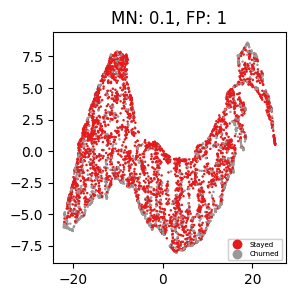

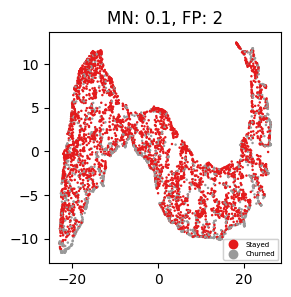

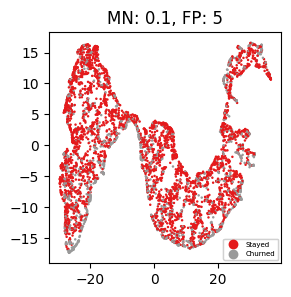

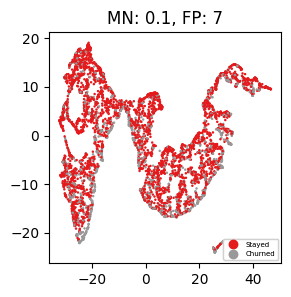

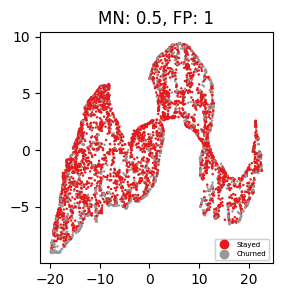

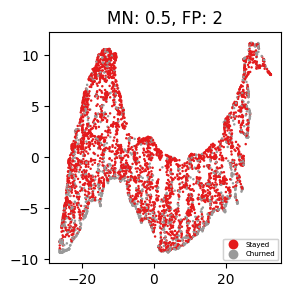

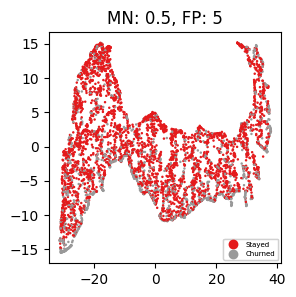

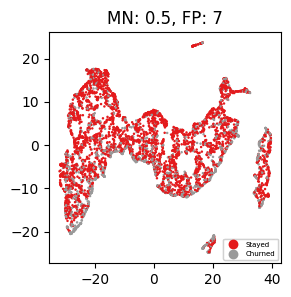

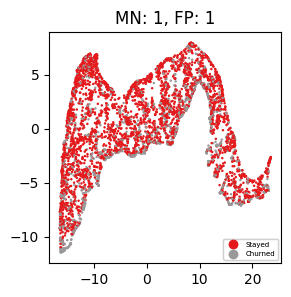

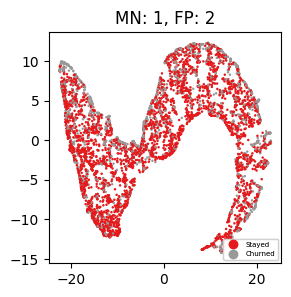

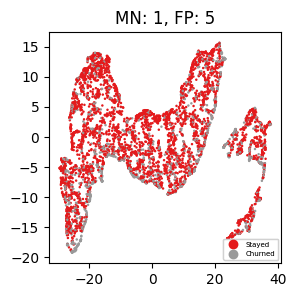

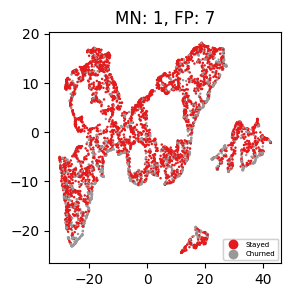

In [7]:
X_train_numeric = df_X_train_imp.select_dtypes(exclude=['category'])
y_train_numeric = df_y_train.map({'Stayed': 0, 'Churned': 1}).astype('float')

mn_ratio_list = [0.1, 0.5, 1]
fp_ratio_list = [1, 2, 5, 7]

pacmap_params_list = [mn_ratio_list, fp_ratio_list]

for element in itertools.product(*pacmap_params_list):
    # initializing the pacmap instance
    # Setting n_neighbors to "None" leads to a default choice shown below in "parameter" section
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=element[0], FP_ratio=element[1]) 

    # fit the data (The index of transformed data corresponds to the index of the original data)
    X_transformed = embedding.fit_transform(X_train_numeric.values, init="pca")

    # visualize the embedding
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    scatter = ax.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="Set1", c=y_train_numeric, s=0.6)

    plt.title(f'MN: {element[0]}, FP: {element[1]}')

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(scatter.legend_elements()[0],
                        ['Stayed', 'Churned'],
                        loc="lower right", 
                        fontsize=5)
    ax.add_artist(legend1)

plt.show()

# Modeling
***

## GOSDT

In [9]:
config_param_dict = {
            "regularization": [0.01, 0.1],
            "depth_budget": [5, 10],
            "time_limit": [120],
            "similar_support": [False]
         }

validator = GridSearchCVGOSDT(model=CustomGOSDT,
                              param_dict=config_param_dict,
                              metric='F1 Score',
                              folds=5)

with warnings.catch_warnings():
   warnings.simplefilter("ignore")
   results = validator.run_validation(X=X_train_numeric,
                                       y=y_train_numeric,
                                       n_est=10,        # number of estimators for guessing thresholds
                                       max_depth=5,     # max_depth for the estimator, not the GOSDT
                                       verbose=1)



Fold: 1
gosdt reported successful execution
training completed. 0.000/0.000/30.333 (user, system, wall), mem=0 MB
bounds: [0.212913..0.212913] (0.000000) loss=0.172913, iterations=177655
Model training time: 0.0
Training accuracy: 82.7%
# of leaves: 4
{'regularization': 0.01, 'depth_budget': 5, 'time_limit': 120, 'similar_support': False, 'warm_LB': True, 'path_to_labels': '/tmp/warm_lb_labels/warm_label.tmp', 'F1 Score': 0.6206896551724138}

Best Result:
{'regularization': 0.01, 'depth_budget': 5, 'time_limit': 120, 'similar_support': False, 'warm_LB': True, 'path_to_labels': '/tmp/warm_lb_labels/warm_label.tmp', 'F1 Score': 0.6206896551724138}


: 